In [1]:
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import evcouplings.align, evcouplings.couplings

from lib import *

In [2]:
counter = count_kmers_proteome(human, 9)

In [3]:
df = counter_to_df(counter, norm=False)

In [4]:
seqmat = np.random.choice(df['seq'], p=df['count']/np.sum(df['count']), size=1000000)
seqmat = np.array([list(seq) for seq in seqmat])
seqmat

array([['L', 'E', 'T', ..., 'L', 'S', 'K'],
       ['E', 'P', 'A', ..., 'A', 'E', 'E'],
       ['D', 'R', 'K', ..., 'S', 'K', 'I'],
       ...,
       ['E', 'G', 'Q', ..., 'P', 'T', 'D'],
       ['P', 'S', 'S', ..., 'P', 'S', 'K'],
       ['V', 'D', 'L', ..., 'G', 'Y', 'M']], dtype='<U1')

In [60]:
map_ = map_ = {c: i for i, c in enumerate(aminoacids)}
mapped_seqmat = evcouplings.align.map_matrix(seqmat, map_)

In [61]:
fi = evcouplings.align.frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids))

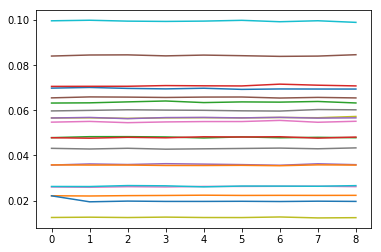

In [8]:
plt.plot(fi);

In [9]:
fij = evcouplings.align.pair_frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids), fi=fi)

In [10]:
cij = evcouplings.couplings.compute_covariance_matrix(fi, fij)

In [11]:
invC = np.linalg.inv(cij)

In [12]:
Jij = evcouplings.couplings.reshape_invC_to_4d(invC,
                seqmat.shape[1],
                len(aminoacids))

In [13]:
Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)

In [20]:
Jij.shape, hi.shape

((9, 9, 20, 20), (9, 20))

In [46]:
hi = evcouplings.couplings.fields(Jij, fi)
print(hi)

#for i in range(hi.shape[0]):
#    for a in range(hi.shape[1]):
#        hi[i, a] += np.sum(Jij[i, :, a, :])

[[-1.54358693 -2.07270845 -0.80468815 -1.41752994 -0.63186966 -0.92155894
  -1.56749297 -0.82109498 -1.1076127  -0.76008308 -2.05347801 -1.13541913
  -1.74335556 -1.66874481 -1.21077571 -1.35028734 -1.24097355 -1.20268742
  -2.66716701  0.        ]
 [-2.02628489 -2.37619276 -1.213346   -1.9183758  -0.75214758 -1.24382222
  -1.77635364 -1.25914133 -1.62692754 -1.19852467 -2.31519811 -1.35516518
  -2.05696404 -1.93688219 -1.78411355 -1.61970629 -1.62946167 -1.71629358
  -2.92718915  0.        ]
 [-1.64667488 -1.5755443  -0.68724974 -1.45512976 -0.45754653 -0.94936954
  -1.40425576 -0.8966046  -1.10688796 -0.9505373  -1.64225758 -0.86318387
  -1.66892635 -1.55584482 -1.23878323 -1.35729861 -1.23175403 -1.26107095
  -2.60779649  0.        ]
 [-1.8559691  -1.55620142 -0.83387965 -1.59795891 -0.80750258 -1.08214028
  -1.82357292 -1.01721964 -1.21589382 -1.04060444 -1.77854664 -0.83491727
  -1.78616235 -1.78487647 -1.48466656 -1.47614323 -1.55216619 -1.59166288
  -2.29090254  0.        ]
 [-1

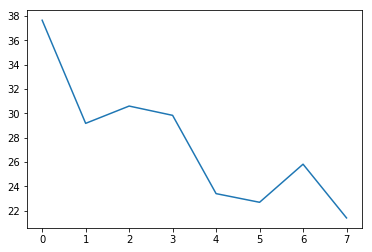

In [301]:
plt.plot([np.abs(Jij_zerogauge[0, i]).sum() for i in range(1,seqmat.shape[1])])

In [148]:
import numba
@numba.jit(nopython=True)
def energy_ising(x, hi, Jij):
    e = 0
    for i in range(len(x)):
        e += hi[i, x[i]]
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            e += Jij[i, j, x[i], x[j]]
    return -e

In [180]:
jump = lambda x: ''.join(np.random.choice(list(aminoacids), size=9))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(evcouplings.align.map_matrix(list(x), map_),
                                                 np.log(fi), -Jij_zerogauge), jump, 1e6)

In [181]:
fi_model = evcouplings.align.frequencies(evcouplings.align.map_matrix([list(s) for s in samples], map_), np.ones(len(samples)), num_symbols=len(aminoacids))

In [182]:
fij_model = evcouplings.align.pair_frequencies(evcouplings.align.map_matrix([list(s) for s in samples], map_), np.ones(len(samples)), num_symbols=len(aminoacids), fi=fi_model)

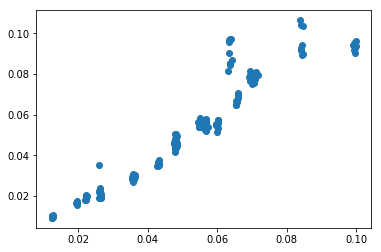

In [183]:
plt.plot(fi.flatten(), fi_model.flatten(), 'o')

In [185]:
cij_model = evcouplings.couplings.compute_covariance_matrix(fi_model, fij_model).flatten()

(-0.01, 0.01)

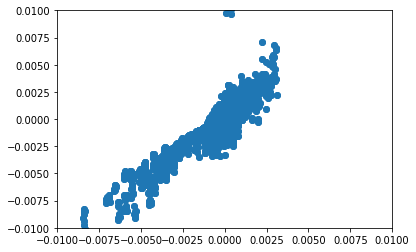

In [189]:
plt.plot(cij.flatten(), cij_model.flatten(), 'o')
plt.xlim(-0.01, 0.01) 
plt.ylim(-0.01, 0.01)

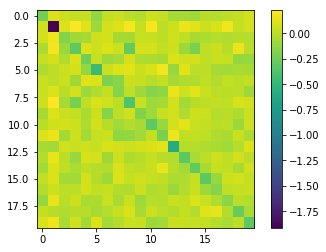

In [315]:
plt.imshow(Jij_zerogauge[0,3])
plt.colorbar()

In [306]:
cij_reshaped = evcouplings.couplings.reshape_invC_to_4d(cij,
                seqmat.shape[1],
                len(aminoacids))

/home/amayer/.conda/envs/immune/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


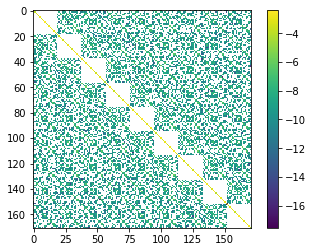

In [332]:
plt.imshow(np.log(cij))
plt.colorbar()

In [259]:
evcouplings.couplings.fields(Jij, fi)

array([[-0.58948613, -1.49454664, -0.06356165, -0.66337832, -0.2171583 ,
        -0.20599974, -1.12149109, -0.34826784, -0.4652226 , -0.18996467,
        -1.20533431, -0.3586272 , -0.82946664, -0.89649406, -0.57285944,
        -0.54598427, -0.48298814, -0.49362122, -1.92228331,  0.        ],
       [-1.12351143, -1.54950611, -0.49046486, -0.88549072, -0.31541571,
        -0.53927169, -1.3333736 , -0.67071048, -0.59192545, -0.34619445,
        -1.37216552, -0.71211838, -1.06653231, -1.14273861, -0.60002826,
        -0.70608306, -0.8707877 , -0.7707656 , -2.26722117,  0.        ],
       [-1.03143766, -0.90326623, -0.49892468, -0.77711307, -0.3381534 ,
        -0.57145138, -1.27959186, -0.33247223, -0.5609431 , -0.32427995,
        -1.58490899, -0.53115011, -1.0159358 , -0.92859568, -0.65171482,
        -0.57381468, -0.82887568, -0.58381621, -1.89875207,  0.        ],
       [-1.08447151, -0.8175469 , -0.4356856 , -0.77175087, -0.35510648,
        -0.65782131, -1.2214273 , -0.48076711, -

In [111]:
alignment = evcouplings.align.Alignment(seqmat,
                                        sequence_ids=[str(i)+'/1-4' if i == 0 else '' for i in range(len(seqmat))],
                                        alphabet=evcouplings.align.ALPHABET_PROTEIN_NOGAP)

ValueError: Default - is not in alphabet ACDEFGHIKLMNPQRSTVWY

In [101]:
mfdca = evcouplings.couplings.MeanFieldDCA(alignment)

In [102]:
fit = mfdca.fit(pseudo_count=0.5)

In [103]:
fit.J_ij.shape

(4, 4, 21, 21)

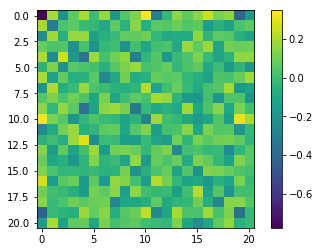

In [110]:
plt.imshow(evcouplings.couplings.model._zero_sum_gauge(fit.J_ij)[0, 1])
plt.colorbar()